In [1]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE

def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn

# dir = os.path.dirname(os.path.realpath(__file__))
# os.chdir(dir)

# get directory above
main_dir = "/Users/davidvandijcke/Dropbox (University of Michigan)/rdd" # moveUp(dir, 4) #  "/home/dvdijcke/" 
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out')  

### Convex relaxation image example

In [10]:

#------------------------
## boe lifted image

boe = cv2.imread(os.path.join(data_in, 'manchester.jpeg'), cv2.IMREAD_GRAYSCALE)
# resize
boe = cv2.resize(boe, (0,0), fx=1, fy=1)

Y = boe.flatten()
X = np.stack(np.meshgrid(*[np.arange(boe.shape[1]), np.arange(boe.shape[0])]), axis = -1)
X = X.reshape(-1, 2)

resolution = 1/int(np.sqrt(Y.size*1))
model = FDD(Y, X, level = 16, lmbda = 70, nu = 0.001, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True)



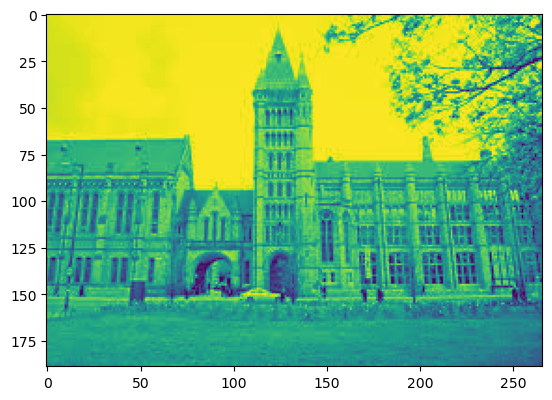

In [11]:
plt.imshow(boe)

In [12]:
# modify function to return lifted image as well
from types import MethodType

def run(self):

    f, repeats, level, lmbda, nu, tol = \
        self.arraysToTensors(self.grid_y, self.iter, self.level, self.lmbda, self.nu, self.tol)

    if self.scripted:
        results = self.model(f, repeats, level, lmbda, nu, tol)
    else:
        results = self.model.forward(f, repeats, level, lmbda, nu, tol)

    v, nrj, eps, it = results

    u, jumps, J_grid, nrj, eps, it = self.processResults(results)

    return (u, jumps, J_grid, nrj, eps, it, v)

model.run = MethodType(run, model)


In [13]:
u, jumps, J_grid, nrj, eps, it, v = model.run()


In [14]:
def isosurface_lifted(u, grid_y):

    mask = (u[...,:-1] > 0.5) & (u[...,1:] <= 0.5)
    # Find the indices of the first True value along the last dimension, and set all the following ones to False
    mask[..., 1:] = (mask[..., 1:]) & (mask.cumsum(-1)[...,:-1] < 1)

    uk0 = u[...,:-1][mask]
    uk1 = u[...,1:][mask]

    # get the indices of the last dimension where mask is True
    k = np.where(mask == True)[-1] + 1

    #h_img = self.interpolate(k, uk0, uk1, self.level).reshape(self.grid_y.shape[:-1])

    return k.reshape(grid_y.shape[:-1])

test = isosurface_lifted(v.cpu().detach().numpy(), model.grid_y)
test = test / test.max()

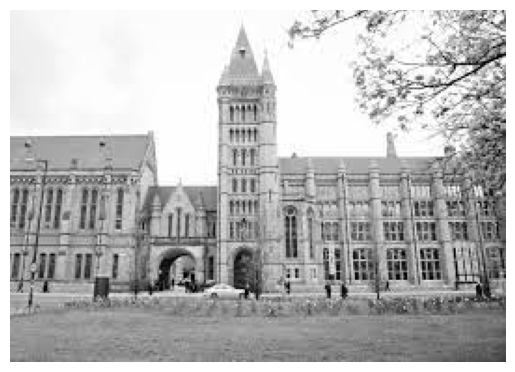

In [15]:
plt.imshow(boe, cmap='gray')
plt.axis("off")
plt.savefig("boe_input.png", bbox_inches="tight")

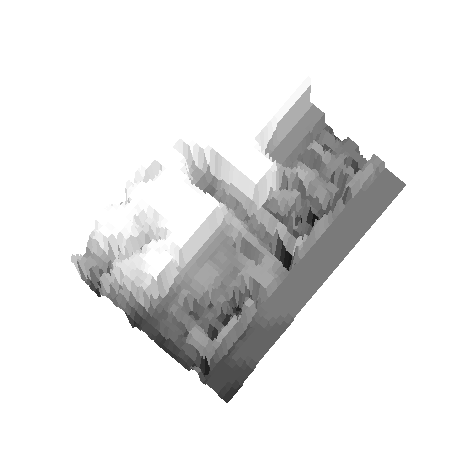

In [16]:
# Create a new figure
fig = plt.figure()

# Add 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot surface
ax.plot_surface(model.grid_x[...,1], model.grid_x[...,0], test, cmap="gray", linewidth=0, antialiased=False, alpha=None)

# Set the view angle
ax.view_init(elev=80, azim=40)

# "Zoom out" by setting larger limits on the axes
x_range = model.grid_x[...,1].ptp()
y_range = model.grid_x[...,0].ptp()
z_range = test.ptp()

# ax.set_xlim(model.grid_x[...,1].min() - 0.1 * x_range, model.grid_x[...,1].max() + 0.1 * x_range)
# ax.set_ylim(model.grid_x[...,0].min() - 0.1 * y_range, model.grid_x[...,0].max() + 0.1 * y_range)
# ax.set_zlim(test.min() - 0.1 * z_range, test.max() + 0.1 * z_range)

#ax.axis("off")
# Display the plot
ax.axis("scaled")
ax.axis("off")
#plt.show()
plt.tight_layout()
plt.savefig("boe_lifted.png", bbox_inches="tight")

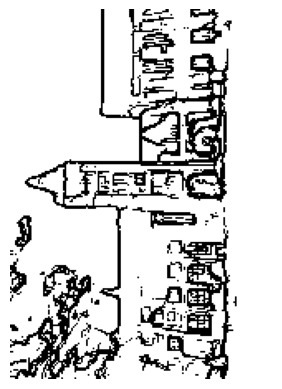

In [17]:
plt.imshow(J_grid, cmap="binary")
plt.axis("off")
plt.savefig("boe_Jgrid.png", bbox_inches="tight")

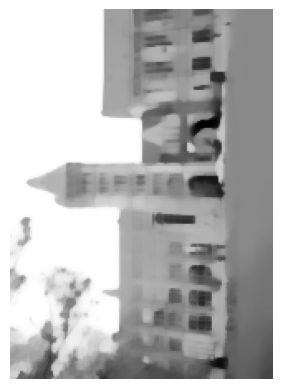

In [18]:
plt.imshow(u, cmap="gray")
plt.axis("off")
plt.savefig("boe_u.png", bbox_inches="tight")

## Lifted subgraph figure

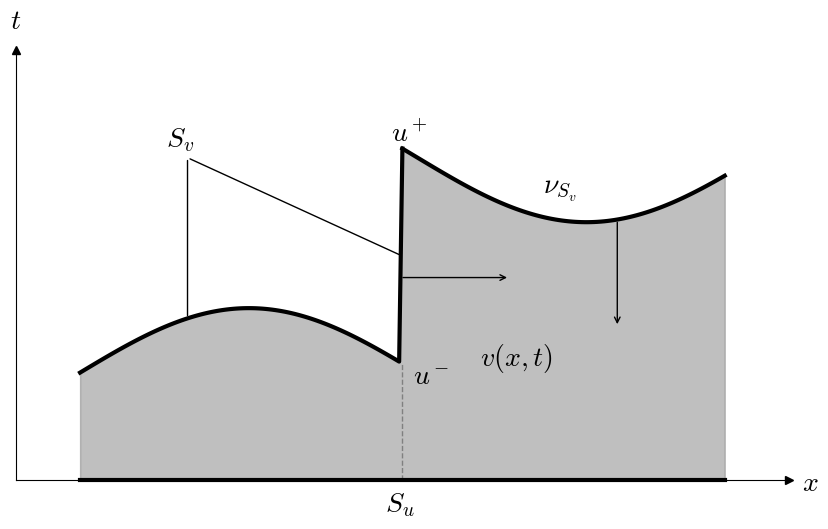

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Given code

plt.figure(figsize=(10, 6))
line_width = 3
fsize = 20

# Create a nonlinear function with a jump at S_u
def u(x):
    return 0.5 + np.sin(x * 2) *0.3  + np.where(x >= S_u, 1, 0)

S_u = 1.5
x_left = np.linspace(0, S_u, 100)
x_right = np.linspace(S_u, 3, 100)
x_jump = np.array([S_u])

plt.plot(x_left, u(x_left), 'k-', lw=line_width, label=r'$u(x)$')
plt.plot(x_right, u(x_right), 'k-', lw=line_width)
plt.fill_between(np.concatenate([x_left, x_jump, x_right]), 0, u(np.concatenate([x_left, x_jump, x_right])), color='grey', alpha=0.5)

jump_bottom = u(S_u - 0.001)
plt.plot([S_u, S_u], [0, jump_bottom], color='grey', linestyle='--', lw=1)

jump_mid = (u(S_u - 0.001) + u(S_u + 0.001)) / 2
plt.plot([x_left[0], x_right[-1]], [0, 0], 'k-', lw=line_width)
plt.xticks([])
plt.yticks([])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.annotate(r'$u^+$', (S_u, u(S_u + 0.001)), textcoords="offset points", xytext=(5,5), ha='center', fontsize=fsize)
plt.annotate(r'$u^-$', (S_u + 0.1, u(S_u - 0.001)), textcoords="offset points", xytext=(5,-15), ha='center', fontsize=fsize)
plt.annotate(r'$S_v$', (0.4, 1.55), fontsize=fsize)
plt.annotate('', xy=(0.5, u(0.5)), xytext=(0.5, 1.5), arrowprops=dict(arrowstyle='-', lw=1, color='black'))
plt.annotate('', xy=(S_u, jump_mid), xytext=(0.5, 1.5), arrowprops=dict(arrowstyle='-', lw=1, color='black'))
ax.spines["left"].set_position(("data", -0.3))
ax.spines["bottom"].set_position(("data", 0))
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(-0.3, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
ax.spines["left"].set_bounds(0, 2)
plt.annotate(r"$S_u$", (S_u - 0.08, -0.15), fontsize=fsize)
plt.annotate('', xy=(S_u-0.01, jump_mid-0.1), xytext=(S_u + 0.5, jump_mid-0.1), arrowprops=dict(arrowstyle='<-', lw=1, color='black'))
plt.annotate('', xy=(S_u+1, u(S_u+1)), xytext=(S_u+1, u(S_u+1) - 0.5), arrowprops=dict(arrowstyle='<-', lw=1, color='black'))
plt.ylim(-0.15, 2)
plt.xlim(-0.3,3.3)

# add $\nu_{S_v}$ to plot 
plt.annotate(r'$\nu_{S_v}$', (2.2, 1.3), textcoords="offset points", xytext=(5,5), ha='center', fontsize=fsize)

plt.annotate(r'$v(x,t)$', (2, 0.5), textcoords="offset points", xytext=(5,5), ha='center', fontsize=fsize)

# add "x" below end of x axis and "t" to left of y axis
plt.annotate(r"$x$", xy=(1, 0), xytext=(3.4, -0.05), ha='center', fontsize=fsize)
plt.annotate(r"$t$", xy=(0, 1), xytext=(-0.3, 2.1), ha='center', fontsize=fsize)

# Adjust the aspect ratio
ax.set_aspect('equal', 'box')

# computer modern font
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


# save fig with approximately equal width and length
plt.savefig("subgraph.pdf", bbox_inches="tight")